In [1]:
import os
import toml
import wandb
from pycocotools.coco import COCO
import numpy as np
import torch
import torch.nn as nn
import skimage.io as io

import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms.functional as tf
from torch.utils.data import DataLoader

from src.utils import set_seed
from src.dataloader import COCODataset, Transformations, COCODatasetInference
from src.model import DeepLabV3
from src.train_utils import train_model

In [2]:
DATA_PATH = "/home/glebk/Datasets/dataset_ocr" 


In [3]:
cfg = toml.load("/home/glebk/VSProjects/projects/tmp/src/cfg.toml")
cfg

{'img_size': [600, 400],
 'mask_size': [76, 51],
 'p_hflip': 0.5,
 'p_vflip': 0.5,
 'wandb_logging': True,
 'n_iter': 10000,
 'n_iter_val': 100,
 'lr': 0.001,
 'bs_train': 3,
 'bs_val': 1,
 'save_best_val': True,
 'clip_grad': False,
 'checkpoint_path': './weights',
 'n_classes': 3,
 'n_blocks': [3, 4, 10, 3],
 'atrous_rates': [6, 12, 18],
 'multi_grids': [1, 2, 4],
 'output_stride': 8,
 'seed': 123}

In [4]:
set_seed(cfg["seed"])

In [5]:
t_train = Transformations(cfg["img_size"], cfg["p_hflip"], cfg["p_vflip"], cfg["mask_size"])
t_test = Transformations(cfg["img_size"], 0, 0, cfg["mask_size"])


In [6]:
annot_file_train = os.path.join(DATA_PATH, "train_tf" + ".json")
coco_train = COCO(annot_file_train)
dataset_train = COCODataset(coco_train, DATA_PATH, t_train)

annot_file_test = os.path.join(DATA_PATH, "test" + ".json")
coco_test = COCO(annot_file_test)
dataset_test = COCODataset(coco_test, DATA_PATH, t_test)


loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [7]:
# idx = np.random.randint(len(dataset_test))
# img, mask, resized_mask = dataset_test[idx]

# fig, ax = plt.subplots(1, 3, figsize=(12, 12), sharey=False)
# ax[0].imshow(tf.to_pil_image(img))
# ax[1].imshow(mask[0])
# ax[2].imshow(resized_mask[0])

In [8]:
# if cfg["wandb_logging"]:
#     wandb.init(project="OCR", entity="glebk")
#     wandb.config = cfg


In [9]:
train_loader = DataLoader(dataset_train, batch_size=cfg["bs_train"], shuffle=True)
val_loader = DataLoader(dataset_test, batch_size=cfg["bs_val"], shuffle=False)

print(len(train_loader))
print(len(val_loader))


286
170


In [10]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = DeepLabV3(
    n_classes=cfg["n_classes"],
    n_blocks=cfg["n_blocks"],
    atrous_rates=cfg["atrous_rates"],
    multi_grids=cfg["multi_grids"],
    output_stride=cfg["output_stride"],
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=cfg["lr"])
scheduler = None
# scheduler = torch.optim.lr_scheduler.StepLR(
#     optimizer, step_size=2500, gamma=0.95, verbose=True
# )

loss = nn.CrossEntropyLoss()

In [ ]:
train_model(model, train_loader, val_loader, device, optimizer, scheduler, cfg, loss)


# Inference

In [10]:
from src.utils import load_model, plot_batch_sample_inference, infer_img, ErodeDilate
from src.losses import jaccard, score_model

In [11]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = DeepLabV3(
    n_classes=cfg["n_classes"],
    n_blocks=cfg["n_blocks"],
    atrous_rates=cfg["atrous_rates"],
    multi_grids=cfg["multi_grids"],
    output_stride=cfg["output_stride"],
).to(device)

In [12]:
WEIGHTS = "/home/glebk/VSProjects/projects/tmp/weights/DeepLabV3_0.094.pth"
model = load_model(WEIGHTS, model, device)

In [13]:
dl = iter(val_loader)

/home/glebk/VSProjects/venvs/torch_basic/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


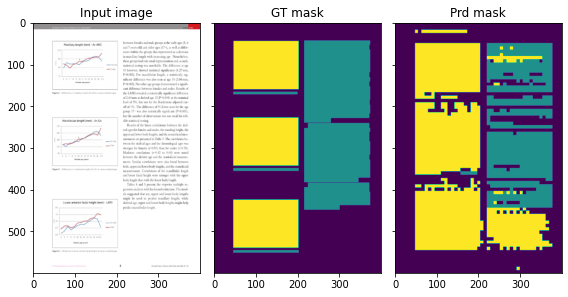

In [14]:
batch = img, _, mask = next(dl)
plot_batch_sample_inference(model, batch, device)

In [18]:
postproc = ErodeDilate(3, 5, 2)

In [19]:
score_model(model, val_loader, device, postproc)

100%|██████████| 170/170 [00:10<00:00, 16.68it/s]


(array([0.8142967 , 0.72674878, 0.86751583]),
 array([0.06435682, 0.18519847, 0.06959812]))

In [17]:
score_model(model, val_loader, device, None)

100%|██████████| 170/170 [00:10<00:00, 16.97it/s]


(array([0.80714654, 0.74804312, 0.86306422]),
 array([0.05893561, 0.18161993, 0.06908823]))

In [ ]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(1, 3, figsize=(16, 6), sharey=True)

for i, metric in enumerate(metrics):
  name, mu, mru = metric
  ax[i].bar(x - width/2, mu[0], width, label='UNet')
  ax[i].errorbar(x - width/2, mu[0], yerr=mu[1], fmt='.k')
  ax[i].bar(x + width/2, mru[0], width, label='ResUNet')
  ax[i].errorbar(x + width/2, mru[0], yerr=mru[1], fmt='.k')

  ax[i].set_title(name)
  ax[i].set_xticks(x)
  ax[i].set_xticklabels(labels)
  ax[i].legend()
  
ax[0].set_ylabel('Scores')
fig.tight_layout()

In [14]:
annot_file_test = os.path.join(DATA_PATH, "test" + ".json")
coco_test = COCO(annot_file_test)
dataset_test = COCODatasetInference(coco_test, DATA_PATH, cfg["img_size"])

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [96]:
img, orig_img = dataset_test[15]
orig_img.shape

torch.Size([3, 792, 601])

In [99]:
postproc = ErodeDilate(3, 5, 2)

In [101]:
img = infer_bboxes(model, img, orig_img, device, postproc)

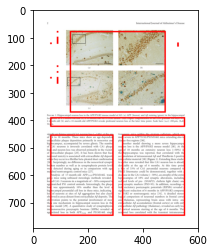

In [102]:
plt.imshow(img)